<center>
    <header
</center>

<img src="Baja.png" width=600 height=400/>

Yeah, we built that ^

# How to Win Baja SAE
### Nicolas Sarfaraz

<hr>

## 1. Introduction

### 1.1 Background on the Competition and Our Team

Baja SAE is a collegiate design competition put on by the [SAE](https://www.sae.org/) (Society of Automotive Engineers), as part of their [Collegiate Design Series](https://www.sae.org/attend/student-events/). Started back in 1976 at the University of South Carolina, the competition challenges college teams from around the world to design, build, and race single-seat, all-terrain vehicles. The goal is to provide engineering students with the opportunity to tackle design projects and challenges similar to those they might face in the real world.  
In 1982, the University of Maryland began participating in the SAE Collegiate Design Series competitions under the name Terps Racing. Today, the team competes the Baja, Formula, and Formula Electric competitions. For more information on our team, feel free to check out our [website](http://racing.umd.edu/about).

### 1.2 Structure and Scoring

Each year, the SAE organizes three competitions in North America: one in the East, one in the Midwest, and one in the West. Up until recently, teams have been able to register for as many competitions as they could manage each year, although a recent change in the registration process has made attending all three competitions much more difficult for the 2020 competition season. At the beginning of each competition, each team must go through a rigorous technical inspection, to ensure that their vehicle satisfies all the series rules and safety regulations. Teams that do not pass this inspection are prohibited from participating in any of the dynamic events (more on this below).  
Over the years, slight changes have been made in the scoring system; however, since 2012, the competition has been scored out of 1000 points total. Each competition is split up into static events and dynamic events, which make up 300 and 700 points respectively. The static events take place on the first day of competition, and currently consist of a Design Evaluation (150 points), Prototype Cost (100 points), and Sales Presentation (50 points). These events are meant to emulate the business and marketing side of product engineering, and have more to do with how well teams can present than with the actual performance of their vehicles. Dynamic events are held over the course of the next two days. The first day events aim to test individual car characteristics independently. Currently, these consist of Acceleration, Maneuverability, Traction (Hill Climb or Sled Pull), and a Specialty Event (Suspension, Rock Crawl, Mud Bog, etc.), each of which is worth 75 points. Finally, the competition culminates in a four-hour, wheel-to-wheel Endurance race, which accounts for a whopping 400 points and tests overall vehicle performance.

### 1.3 Objectives and Limitations

One of the most interesting parts of the Baja SAE competition is that every team is required to use the same unmodified, 10-horsepower, Briggs & Stratton engine. This means that every team starts on equal footing in terms of power. In addition, teams are all held to fairly similar rollcage layouts, for safety reasons. The result is that winning Baja SAE is about optimizing every other component, to make the most of the limited power available. The original intention, and ultimate goal of this project is to undertand how specific vehicle characteristics (i.e. wheelbase, track width, weight, etc.) affect team ranking. Each engineering decision has both pros and cons. For instance, making a vehicle shorter makes it more maneuverable, but less stable. Ideally, we could train a model to take in all the results from previous years, to determine what the the ideal vehicle might look like. Unfortunately, these vehicle characteristics hard to come by without contacting teams individually, not to mention that many prefer to keep exact numbers to themselves.  
Still, there is a lot to be gained from analysing result trends over the past decade or so. In particular, it will be interesting to relate performance in each individual event to overall ranking. Although the Endurance event makes up the most significant portion of points, it is difficult to quantify what goes into winning, since so many factors are at play. In an effort to narrow down what aspects of the vehicle are most critical and nail down some target metrics, we'll take a look at which first-day dynamic events correlate most strongly with overall wins. The hope is that this analysis can help guide design decisions in the years to come.

Note: The source for most of the above information is the Baja SAE 2020 Rulebook, which can be found on the Baja SAE [Series Resources](https://www.bajasae.net/cdsweb/gen/DocumentResources.aspx) page under the SAE tab.

<hr>

## 2. Getting Started with the Data

### 2.1 First, an Aside

The Baja SAE [Results](https://www.bajasae.net/res/ResultsLanding.aspx) page provides access to competition results starting in 2016, and has links to records going back to 1996. Unfortunately, as of writing this, it appears that their [Recent Results](https://www.bajasae.net/page.aspx?pageid=2d2a2ef4-55fe-40e3-a67b-91dd0ca1a6ec) page, which should contain the data files from the years 2014 onwards, is not working. Additionally, while competitions have been scored out of 1000 points since 2012, they have only had a consistent scoring structure similar to the current system starting in 2013. Thus, although the 2013 data is still available on the [Results Archive](http://students.sae.org/competitions/bajasae/results/) page, we prefer to just look at the results from 2016 to 2019, rather than gain only one additional year of data, at the cost of including a two-year gap. Beyond that, the lack of access to the data files will force us to scrape the data directly from the website HTML. To do this, we'll be using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), which is a really helpful parser for web pages.  
We'll be looking at how teams performed in the dynamic events, since these are the ones that test the vehicles' actual capabilites, and how performance in each relates to overall success. In particular, we'll be looking at how success in each of the individual dynamic events correlates to success in the endurance race.

### 2.2 Importing the Necessary Libraries

Our first step in analysing the competition data is to import some important libraries, which will help us to organize, plot, and analyse our data. In addition, as mentioned above, we'll need some additional tools to scrape the results data from the Baja SAE [website](https://www.bajasae.net/).

In [1]:
# General math and data management libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as mat
import seaborn as sb

# Libraries to help us deal with html
from bs4 import BeautifulSoup as bs
import requests as req

### 2.3 HTML Exploration

As discussed above, we'll be looking at the Baja SAE results from 2016 to 2019. Since three competitions are held each season, this corresponds to twelve different results pages. Additionally, the website separates overall results, which give point summaries and other information, from the five dynamic-event-specific results, which give the actual times and/or distances for each run (for context, in events where not all cars are able to make it to the end, vehicles that do are scored based on time while those that don't are scored based on the distance they cover). This gives us a total of 72 pages to look through!  
Luckily, over the four years we're looking at, the links are all specified by competitionid and eventkey. The first corresponds to a specific competition (year and location), while the second corresponds to an event: OVR for overall, ACCEL for Acceleration, MANU for Maneuverability, TRAC for Traction, SPEC for the Specialty Event, and ENDUR for Endurance. Manually taking note of these will allow us to loop through all the pages automatically, in order to more easily collect our data. We'll keep these values in dictionaries, in case we need to retrieve what they mean.

In [2]:
competitionids = {"541a6d54-f13a-4169-b35d-553ab2e116f6": "2019,Rochester",
                  "09bafb4a-baf7-4c4d-a974-2aa0ac22ba9d": "2019,Tennessee Tech",
                  "a4ae23dc-975b-4d08-a040-225dafb75b31": "2019,California",
                  "5108e3e9-cf27-4ca6-88cf-fea31c6b7ac2": "2018,Maryland",
                  "6bf956b9-4796-4b39-a8e7-8caeb55d5d73": "2018,Kansas",
                  "a8d3752f-aee1-4492-94e7-7cf021a11a65": "2018,Oregon",
                  "6548e906-200b-4e58-91ad-1bcda47091eb": "2017,Illinois",
                  "47889761-684f-4fa2-b057-7abb55c8bbde": "2017,Kansas",
                  "a59bd740-f7f4-46ee-b3a2-6b7d672ccf1e": "2017,California",
                  "ddc22524-5b18-49a0-a416-22c310821c42": "2016,Rochester",
                  "5a13d57d-8d58-41cd-803a-514f15b7a2c0": "2016,Tennessee Tech",
                  "625a80e2-fdb4-4854-bffe-c5d62ab2d492": "2016,California"}

eventkeys = {"OVR": "Overall",
             "ACCEL": "Acceleration",
             "MANU": "Maneuverability",
             "TRAC": "Traction",
             "SPEC": "Specialty",
             "ENDUR": "Endurance"}

First things first, we'll take a look at the HTML for the very first overall results page, just to get an understanding of how the page is structured. The result of this is suppressed here, for the sake of readability, however the same result can be seen by going to the [link](https://www.bajasae.net/res/EventResults.aspx?competitionid=541a6d54-f13a-4169-b35d-553ab2e116f6&eventkey=OVR) and hitting ctrl-shift-C (or cmd-shift-C if you're on a Mac).

In [3]:
URL = "https://www.bajasae.net/res/EventResults.aspx?competitionid="+list(competitionids.keys())[0]+\
      "&eventkey="+list(eventkeys.keys())[0]
resultReq = req.get(URL)
resultRoot = bs(resultReq.content)
#print(resultRoot.prettify())

Now that we know where the data is located within the page's HTML, we can grab it, put it into a DataFrame, and check the first couple entries to make sure everything looks okay.

In [4]:
resultTable = resultRoot.find("table")
resultData = (pd.read_html(str(resultTable)))[0]
resultData.head()

,Rank,Car #,School,Team,Overall (1000),Overall Dynamic (300),Overall Static (300),Cost Event (100),Design (150),Sales Presentation (50),Acceleration (75),Maneuverability (75),Hill Climb (75),Suspension (75),Endurance (400),Comp Penalty,Registered,Passed Tech,Passed Tech On Time,Public Comments
0,1,2,Univ of Michigan - Ann Arbor,Michigan Baja Racing,941.49,266.63,274.86,91.86,135.0,48.0,74.64,75.00,72.78,44.21,400.00,0.0,True,True,True,NaN
1,2,5,Ecole de Technologie Superieure,BAJA ETS,906.60,239.28,283.00,100.00,138.0,45.0,68.99,71.88,58.78,39.63,384.31,0.0,True,True,True,NaN
2,3,78,San Diego State Univ,Aztec Baja,895.70,255.00,264.23,81.23,130.0,53.0,64.61,55.74,64.43,70.22,376.47,0.0,True,True,True,NaN
3,4,3,Cornell Univ,Cornell Baja,841.45,274.64,245.24,78.24,134.0,33.0,72.39,68.24,63.17,70.84,321.57,0.0,True,True,True,NaN
4,5,105,Université Laval,Alérion,809.84,261.16,172.21,88.21,50.0,34.0,64.09,72.67,63.02,61.38,376.47,0.0,True,True,True,NaN


Looking at this, we see that we can drop the columns corresponding to Overall Static, Cost Event, Design, and Sales Presentation, since these all correspond to the static events, which we won't be looking at for our analysis. We can also drop Comp Penalty, Registered, Passed Tech On Time, and Public Comments since these are all administrative details, the meanings of which are not all clear. We will, however, keep the Passed Tech column for now, since it will allow us to get rid of any teams that didn't pass the inspection and were thus unable to participate in the dynamic events. This is something we'll take care of later, once it's time to put all the data together.  
We will follow a similar procedure for the remaining five event tables, in order to see what columns we want to keep. Once again, for the sake of readability, we'll suppress this output, however the data can be seen on the [website](https://www.bajasae.net/res/EventResults.aspx?competitionid=541a6d54-f13a-4169-b35d-553ab2e116f6&eventkey=OVR) by clicking on the corresponding tabs.

In [5]:
# We use indexing here, rather than an iterator, since we can skip the first table, which we already looked at.
for i in range(1,len(eventkeys.keys())):
    URL = "https://www.bajasae.net/res/EventResults.aspx?competitionid="+list(competitionids.keys())[0]+\
          "&eventkey="+list(eventkeys.keys())[i]
    resultReq = req.get(URL)
    resultRoot = bs(resultReq.content)
    resultTable = resultRoot.find("table")
    resultData = (pd.read_html(str(resultTable)))[0]
    #print(resultData.head())

Taking a look at this output, the first thing to note it that the Car Number (Car #), School, and Team columns are already in the Overall results table, so we won't need to copy those, although Car Number will be useful to help match records accross the different tables. The second thing to keep in mind is that the Rank represented in the individual event results are NOT the same as those in the overall results table, but rather the ranks of each team for that particular event. This is something we can recover from the event scores, so we'll only be keeping the Overall Rank, which is our main point of interest.  
In most events, teams are allowed multiple attempts, but it's the best run that determines the score. For this reason, we'll only be keeping Best Time for Acceleration and Maneuverability, Best Time and Best Distance for Traction and the Specialty Event, and Laps for Endurance (this is because the Endurance race lasts four hours for all the teams, and is scored based on the number of laps completed in that time).  

### 2.4 Scraping and Aggregation

Now we're ready to do the same thing for each competition and combine the data over all twelve competitions into one big DataFrame. This will be done in a nested loop to cover every event of every competition. We'll need to add columns for the year and location of each competition, so that things don't get mixed up. For the data to match accross all the competitions, we'll also need to rename the Traction and Specialty events columns of each competition, since the original names reflect the specific event (i.e. Hill Climb or Sled Pull for Traction) held at each competition.

In [6]:
# A DataFrame to hold all of our aggregated results data
results = pd.DataFrame

# We use a nested loop to go through every event of every competition
for competition in competitionids.keys():
    # A DataFrame to hold result data for each competition while we assemble it
    competitionResults = pd.DataFrame
    for event in eventkeys.keys():
        
        # This is the same process we use before to get the result data for each event
        eventURL = "https://www.bajasae.net/res/EventResults.aspx?competitionid="+competition+\
                   "&eventkey="+event
        eventReq = req.get(eventURL)
        eventRoot = bs(eventReq.content)
        eventTable = eventRoot.find("table")
        eventData = (pd.read_html(str(eventTable)))[0]
        
        # From here, what we do will depend on which table we're looking at
        # For the merges, we'll use left merges, since we want to keep all competitor data for now
        if event == "OVR":
            # From the overall results, we want to keep everything except for
            # columns corresponding the static events and administrative details
            competitionResults = eventData.copy()
            
            # We'll ignore errors when dropping data, since not all the column names we want to drop
            # exist for every competition
            # Getting rid of static event data
            competitionResults.drop("Overall Static (300)", axis = 1, inplace = True)
            competitionResults.drop("Cost (100)", axis = 1, inplace = True, errors = "ignore")
            competitionResults.drop("Cost Event (100)", axis = 1, inplace = True, errors = "ignore")
            competitionResults.drop("Design (150)", axis = 1, inplace = True, errors = "ignore")
            competitionResults.drop("Design Event (150)", axis = 1, inplace = True, errors = "ignore")
            competitionResults.drop("Sales Presentation (50)", axis = 1, inplace = True)
            # Getting rid of administrative details
            competitionResults.drop("Comp Penalty", axis = 1, inplace = True)
            competitionResults.drop("Registered", axis = 1, inplace = True)
            competitionResults.drop("Passed Tech On Time", axis = 1, inplace = True)
            competitionResults.drop("Public Comments", axis = 1, inplace = True)
            
            # We also want to rename the traction and specialty event based on the event type
            # The default for the renaming function is to ignore extra keys, which is fine since
            # only one will exist for each type of event
            competitionResults.rename(columns = {"Hill Climb (75)": "Traction (75)"}, inplace = True)
            competitionResults.rename(columns = {"Sled Pull (75)": "Traction (75)"}, inplace = True)
            competitionResults.rename(columns = {"Suspension (75)": "Specialty (75)"}, inplace = True)
            competitionResults.rename(columns = {"Rock Crawl (75)": "Specialty (75)"}, inplace = True)
            competitionResults.rename(columns = {"Suspension & Traction (75)": "Specialty (75)"}, inplace = True)
            competitionResults.rename(columns = {"Suspension and Traction (75)": "Specialty (75)"}, inplace = True)
            
        elif event == "ACCEL" or event == "MANU":
            # From the acceleration and maneuverability results, we only want to keep
            # Best Time, and match it to the rest of our data based on Car Number
            competitionResults = pd.merge(competitionResults, eventData[["Car #", "Best Time"]],
                                          how = "left", on = "Car #")
            colName = eventkeys.get(event) + " Time"
            competitionResults.rename(columns = {competitionResults.columns[-1]: colName}, inplace = True)
            
        elif event == "TRAC" or event == "SPEC":
            # From the traction and the specialty event results, we want to keep
            # Best Time and Best Distance, and match them to the rest of our data based on Car Number
            competitionResults = pd.merge(competitionResults, eventData[["Car #", "Best Time", "Best Distance"]],
                                          how = "left", on = "Car #")
            col1Name = eventkeys.get(event) + " Time"
            col2Name = eventkeys.get(event) + " Distance"
            competitionResults.rename(columns = {competitionResults.columns[-2]: col1Name}, inplace = True)
            competitionResults.rename(columns = {competitionResults.columns[-1]: col2Name}, inplace = True)
            
        elif event == "ENDUR":
            # From the endurance event results, all we want to keep is the number of laps completed,
            # and once again match it to the rest of our data based on Car Number
            competitionResults = pd.merge(competitionResults, eventData[["Car #", "Laps"]],
                                          how = "left", on = "Car #")
            colName = eventkeys.get(event) + " Laps"
            competitionResults.rename(columns = {competitionResults.columns[-1]: colName}, inplace = True)
            
        else:
            raise Exception("Unknown Data")
            
    # Now we can grab the competition year and location corresponding to the competitionid to keep our data separated
    competitionResults['Year'] = (competitionids.get(competition).split(","))[0]
    competitionResults['Location'] = (competitionids.get(competition).split(","))[1]
    
    # Finally, we can append the competition data to our aggregated results data
    # Here, the default merge is outer, but once again, this shouldn't make a difference
    # since we made sure that all our columns match accross all the competitions
    if competition == "541a6d54-f13a-4169-b35d-553ab2e116f6":
        results = competitionResults.copy()
    else:
        results = results.append(competitionResults, ignore_index = True)

results.head()

,Rank,Car #,School,Team,Overall (1000),Overall Dynamic (300),Acceleration (75),Maneuverability (75),Traction (75),Specialty (75),...,Passed Tech,Acceleration Time,Maneuverability Time,Traction Time,Traction Distance,Specialty Time,Specialty Distance,Endurance Laps,Year,Location
0,1,2,Univ of Michigan - Ann Arbor,Michigan Baja Racing,941.49,266.63,74.64,75.00,72.78,44.21,...,True,3.863,47.159,8.692,105.0,0.000,560.0,54.0,2019,Rochester
1,2,5,Ecole de Technologie Superieure,BAJA ETS,906.60,239.28,68.99,71.88,58.78,39.63,...,True,4.006,49.059,10.763,105.0,0.000,502.0,52.0,2019,Rochester
2,3,78,San Diego State Univ,Aztec Baja,895.70,255.00,64.61,55.74,64.43,70.22,...,True,4.117,58.894,9.819,105.0,34.973,580.0,51.0,2019,Rochester
3,4,3,Cornell Univ,Cornell Baja,841.45,274.64,72.39,68.24,63.17,70.84,...,True,3.920,51.279,10.015,105.0,34.666,580.0,44.0,2019,Rochester
4,5,105,Université Laval,Alérion,809.84,261.16,64.09,72.67,63.02,61.38,...,True,4.130,48.576,10.039,105.0,40.012,580.0,51.0,2019,Rochester


As a quick note, although it may look like we managed to take into account all the different naming conventions accross competitions in one go, this was in fact the result of trying and failing a number of times. For instance, trial and error revealed that Cost and Cost Event were used interchangeably, or that some competitions have Suspension and Traction (also named Suspension & Traction) listed as their Specialty Event separate from the main Traction event. Tweaks were made to the code until we ended up with the expected number of colums.  
Another thing that we came accross while processing our data is that competitions occasionally award dynamic event points to teams that have not passed the technical inspection. This is rather puzzling, given that the rules explicitly state that "all Baja SAE® vehicles shall pass a technical inspection before they are permitted to operate under power," which would make it hard for them to participate in these events. It is unclear if this is due to errors in recording the data, exceptions being made, or perhaps a quirk in the scoring procedure, however we will still stick with ignoring teams that didn't pass the inspection. This is mainly because the meaning of the points earned is unclear, not to mention that we're primarily interested in the top-ranked vehicles, which all pass their inspections anyways.

### 2.5 Data Tidying

Now that we have all of our competition data together in one DataFrame, the first thing to do is finally drop all the rows correspoding to teams that didn't pass their technical inspection. Once that's over with, we can drop the Passed Tech column, since the value is True for all the remaining teams. Finally, we'll reset our index.

In [7]:
results = results[results["Passed Tech"] == True]
results = results.drop("Passed Tech", axis = 1)
results.reset_index(drop=True, inplace=True)
results.head()

,Rank,Car #,School,Team,Overall (1000),Overall Dynamic (300),Acceleration (75),Maneuverability (75),Traction (75),Specialty (75),Endurance (400),Acceleration Time,Maneuverability Time,Traction Time,Traction Distance,Specialty Time,Specialty Distance,Endurance Laps,Year,Location
0,1,2,Univ of Michigan - Ann Arbor,Michigan Baja Racing,941.49,266.63,74.64,75.00,72.78,44.21,400.00,3.863,47.159,8.692,105.0,0.000,560.0,54.0,2019,Rochester
1,2,5,Ecole de Technologie Superieure,BAJA ETS,906.60,239.28,68.99,71.88,58.78,39.63,384.31,4.006,49.059,10.763,105.0,0.000,502.0,52.0,2019,Rochester
2,3,78,San Diego State Univ,Aztec Baja,895.70,255.00,64.61,55.74,64.43,70.22,376.47,4.117,58.894,9.819,105.0,34.973,580.0,51.0,2019,Rochester
3,4,3,Cornell Univ,Cornell Baja,841.45,274.64,72.39,68.24,63.17,70.84,321.57,3.920,51.279,10.015,105.0,34.666,580.0,44.0,2019,Rochester
4,5,105,Université Laval,Alérion,809.84,261.16,64.09,72.67,63.02,61.38,376.47,4.130,48.576,10.039,105.0,40.012,580.0,51.0,2019,Rochester


One last thing we can do is check that all the our columns have the types that we'd like, as well as that our final results DataFrame has the number of rows we expect (that is, the sum of the number of vehicles that passed tech for each competition).  
We'll also take this opportunity to note that for teams that participated in multiple competitions for a single year, we will treat each appearance as a separate data point. This is because teams don't perform identically every time, even within a single season. In fact, some teams even make slight modifications between or at competitions.

In [8]:
for column in results.columns:
    print(column, type(results[[column]].values[0,0]))
    
sum = 0
# We use a nested loop to go through every competition
for competition in competitionids.keys():
    
    # This is the same process we use before to get the overall results for every competition
    competitionURL = "https://www.bajasae.net/res/EventResults.aspx?competitionid="+competition+\
               "&eventkey=OVR"
    competitionReq = req.get(competitionURL)
    competitionRoot = bs(competitionReq.content)
    competitionTable = competitionRoot.find("table")
    competitionData = (pd.read_html(str(competitionTable)))[0]
    
    # This time we'll count the number of teams that passed tech at each competition
    passed = competitionData[competitionData["Passed Tech"] == True]
    sum += len(passed.index)

print("")
print("Expected Number of Entries:", sum)
print("Actual Number of Entries:", len(results.index))

Rank <class 'numpy.int64'>
Car # <class 'numpy.int64'>
School <class 'str'>
Team <class 'str'>
Overall (1000) <class 'numpy.float64'>
Overall Dynamic (300) <class 'numpy.float64'>
Acceleration (75) <class 'numpy.float64'>
Maneuverability (75) <class 'numpy.float64'>
Traction (75) <class 'numpy.float64'>
Specialty (75) <class 'numpy.float64'>
Endurance (400) <class 'numpy.float64'>
Acceleration Time <class 'numpy.float64'>
Maneuverability Time <class 'numpy.float64'>
Traction Time <class 'numpy.float64'>
Traction Distance <class 'numpy.float64'>
Specialty Time <class 'numpy.float64'>
Specialty Distance <class 'numpy.float64'>
Endurance Laps <class 'numpy.float64'>
Year <class 'str'>
Location <class 'str'>

Expected Number of Entries: 1034
Actual Number of Entries: 1034


<hr>

## 3. Exploratoration of Results Data

### 3.1 Event Score Correlation to Overall Rank

One of the first things we'd like to check out is which dynamic events correlate most strongly with overall success. This could give us a better idea of which aspects of the vehicle matter most to winning. In order to get correlations in the direction we expect, we'll flip the sign of Rank, such that an increase in the number of points correlates positiely with our (negative) Rank.

In [9]:
eventScores = results.copy()[["Rank", "Acceleration (75)", "Maneuverability (75)",
                              "Traction (75)", "Specialty (75)", "Endurance (400)"]]
eventScores = eventScores.groupby("Rank", as_index = False).mean()
eventScores["Rank"] = -1*eventScores["Rank"]
eventScores.corr()

,Rank,Acceleration (75),Maneuverability (75),Traction (75),Specialty (75),Endurance (400)
Rank,1.000000,0.952345,0.955579,0.926372,0.935983,0.987297
Acceleration (75),0.952345,1.000000,0.913848,0.938921,0.921228,0.922998
Maneuverability (75),0.955579,0.913848,1.000000,0.877597,0.922307,0.934414
Traction (75),0.926372,0.938921,0.877597,1.000000,0.905640,0.901778
Specialty (75),0.935983,0.921228,0.922307,0.905640,1.000000,0.920534
Endurance (400),0.987297,0.922998,0.934414,0.901778,0.920534,1.000000


In order to get a slightly more visually intuitive representation of these numbers, we can plot our correlation matrix as a heatmap using the Seaborne plotting library.

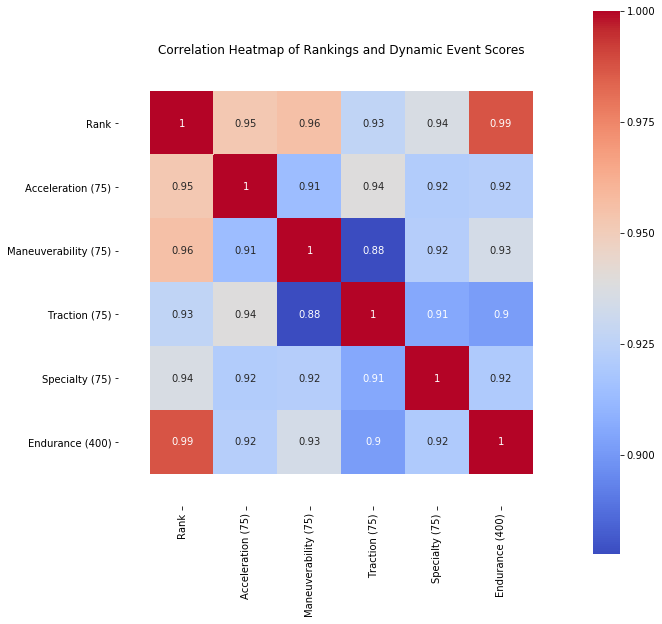

In [10]:
mat.figure(figsize = (10,10))
sb.heatmap(eventScores.corr(), annot = True, cmap = "coolwarm", square = True)
# Unfortunately, a newly introduced bug in the matplotlib library causes the top and bottom
# of our plot to be cut off, unless we reset the axis limits manually.
mat.axis([-0.5, 6.5, 6.5, -0.5])
mat.title("Correlation Heatmap of Rankings and Dynamic Event Scores")
mat.show()

Right off the bat, we notice that these correlations are quite high. This makes sense, since the amount of points won ultimately determines the overall rank, although unfortunately it doesn't really help us much with focusing our efforts.  
Still, we can note that the Endurance score most strongly correlates with Rank, probably beacaue it is worth so many points, followed by Maneuverability and then Suspension. Furthermore, Maneuverability, Acceleration, and the Specialty Event Scores have the strongest correlations with the Endurance Score.

### 3.2 Exploration of Acceleration Results

To get us started, we'll plot a histogram of acceleration results, just to see what kinds of values we're dealing with.

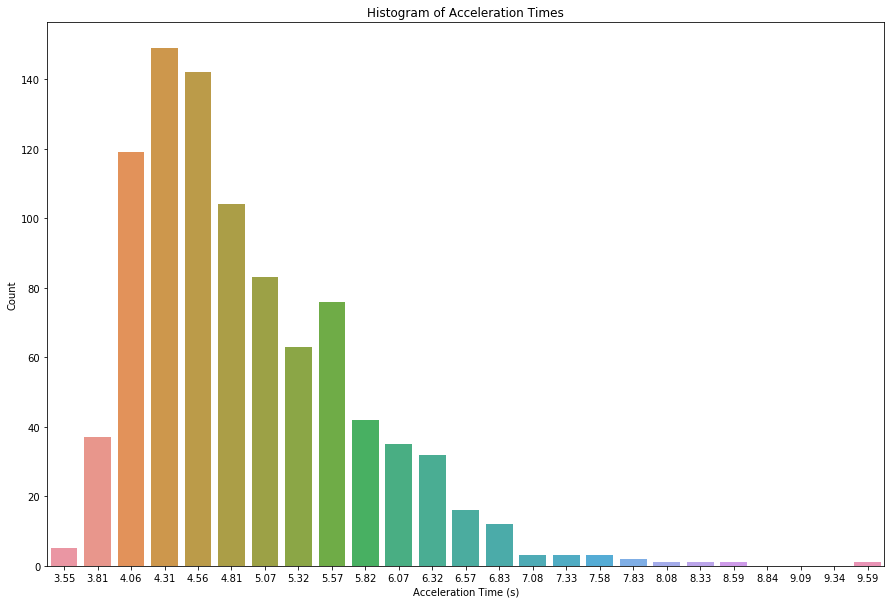

In [11]:
# Splitting the data into bins and counting it
accelerationData = results.copy()[["Acceleration Time"]]
accelerationData["Bins"] = pd.cut(accelerationData["Acceleration Time"], bins = 25)
accelerationData = accelerationData.groupby("Bins", as_index = False).count()
accelerationData["Midpoints"] = accelerationData["Bins"].apply(lambda x: x.mid.round(2))

mat.figure(figsize = (15,10))
sb.barplot(data = accelerationData, x = "Midpoints", y = "Acceleration Time")
mat.xlabel("Acceleration Time (s)")
mat.ylabel("Count")
mat.title("Histogram of Acceleration Times")
mat.show()

According to the rules, the Acceleration event can be run on either a 100 or 150 ft course. As such, we'd expect to see some bi-modality in the Acceleration Times. Although we do see a slight bump around 5.57 s, this seems to be mostly a factor of picking our number of bins to be just right. Still, it's probably safe to assume that the fastest times were recorded on the shorter of the two course lengths, so it looks like a winning vehicle would need to cover 100 ft in around 3.5 seconds, from a standstill. As a side note, the long right tail most likely corresponds to teams with unreliable vehicles.  
We can also look at how Accelertation times have evolved over the years, to see if there are any significant trends. To do this, we'll overlay a scatter plot over some boxplots, which we'll also do using Seaborne.

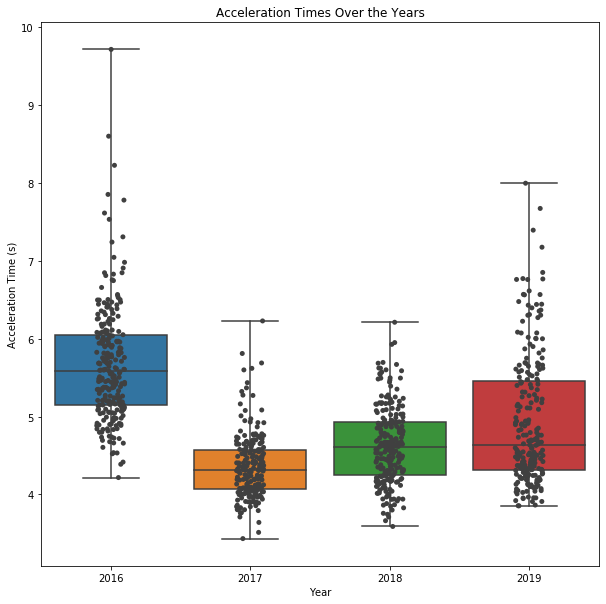

In [12]:
accelerationData = results.copy()[["Year", "Location", "Acceleration Time"]]

mat.figure(figsize = (10,10))
ax = sb.boxplot(data = accelerationData, x = "Year", y = "Acceleration Time", whis=  np.inf)
ax = sb.stripplot(data = accelerationData, x = "Year", y = "Acceleration Time", color = "0.25")
mat.xlabel("Year")
mat.ylabel("Acceleration Time (s)")
mat.title("Acceleration Times Over the Years")
mat.show()

Looking at this, it seems like there is some variation in the median Acceleration times over the years, however it doesn't look this is a linear function of time. This would indicate that vehicles aren't getting much faster anymore, although this could also be skewed by the lengths of each course, which we unforetunately don't know. Still, this makes sense, since the rules have mandated nearly the same 10 horsepower engine for more than a decade. If we were able to look back farther, we might notice a slight increase as manufacturing technologies improved and teams gained access to more advanced materials.

### 3.3 Exploration of Maneuverability Results

Unfortunately, unlike the Acceleration event, there is no prescribed layout or distance for the Maneuverability Event. Still, let's plot this data over the years, just to see what happens.

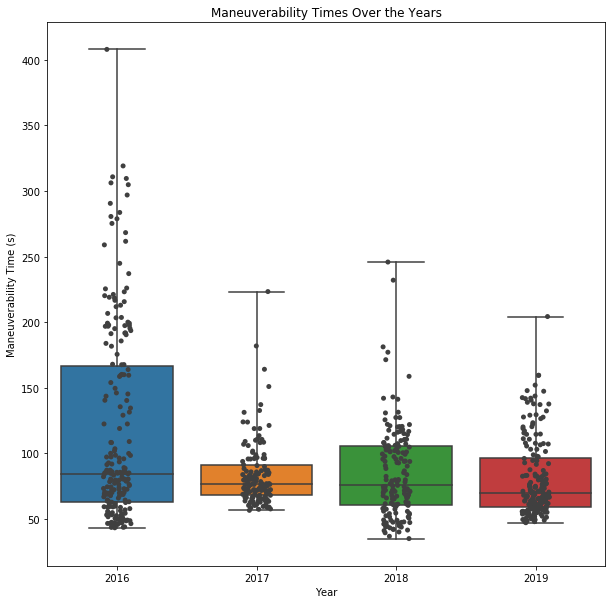

In [13]:
maneuverabilityData = results.copy()[["Rank", "Year", "School", "Location", "Maneuverability Time"]]

mat.figure(figsize = (10,10))
ax = sb.boxplot(data = maneuverabilityData, x = "Year", y = "Maneuverability Time", whis=  np.inf)
ax = sb.stripplot(data = maneuverabilityData, x = "Year", y = "Maneuverability Time", color = "0.25")
mat.xlabel("Year")
mat.ylabel("Maneuverability Time (s)")
mat.title("Maneuverability Times Over the Years")
mat.show()

Shockingly, it looks like the Maneuverability event times are actually more consistent accross the years than the acceleration data, although the scaling is different. Given this development, let's see wha thappends when we plot a histogram of these times, like we did with Acceleration.

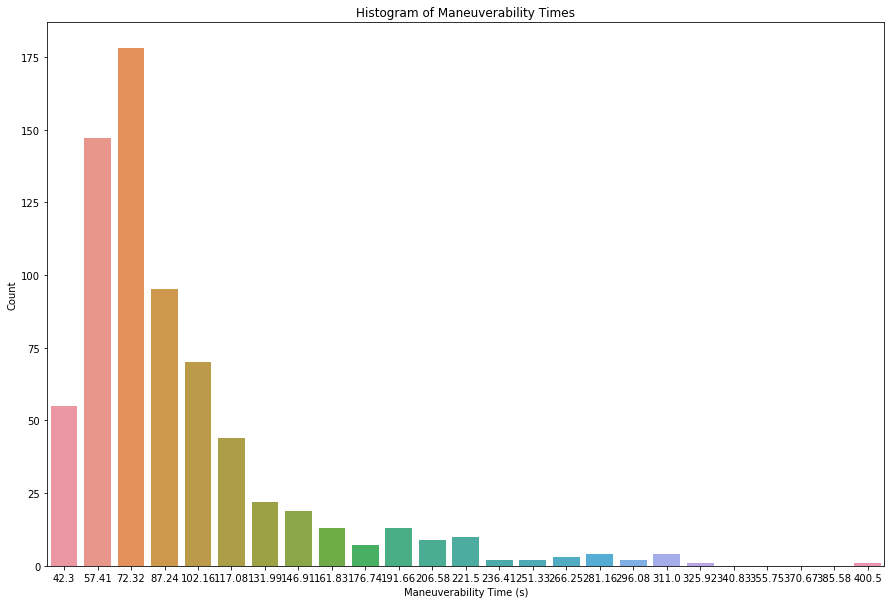

In [14]:
# Splitting the data into bins and counting it
maneuverabilityHist = results.copy()[["Maneuverability Time"]]
maneuverabilityHist["Bins"] = pd.cut(maneuverabilityHist["Maneuverability Time"], bins = 25)
maneuverabilityHist = maneuverabilityHist.groupby("Bins", as_index = False).count()
maneuverabilityHist["Midpoints"] = maneuverabilityHist["Bins"].apply(lambda x: x.mid.round(2))

mat.figure(figsize = (15,10))
sb.barplot(data = maneuverabilityHist, x = "Midpoints", y = "Maneuverability Time")
mat.xlabel("Maneuverability Time (s)")
mat.ylabel("Count")
mat.title("Histogram of Maneuverability Times")
mat.show()

Looking at this data, it looks like the number to beat is around 40 s. Similar to the Acceleration results, we notice an even longe right tail. Here, this probably corresponds to teams making "safe" runs to avoid not finishing and getting no points at all.  
The main flaw in our observation is that the 50+ 40 s times may well be due to a few particularly short or easy Manuverability courses. To check for this, we'll also plot times by rank.

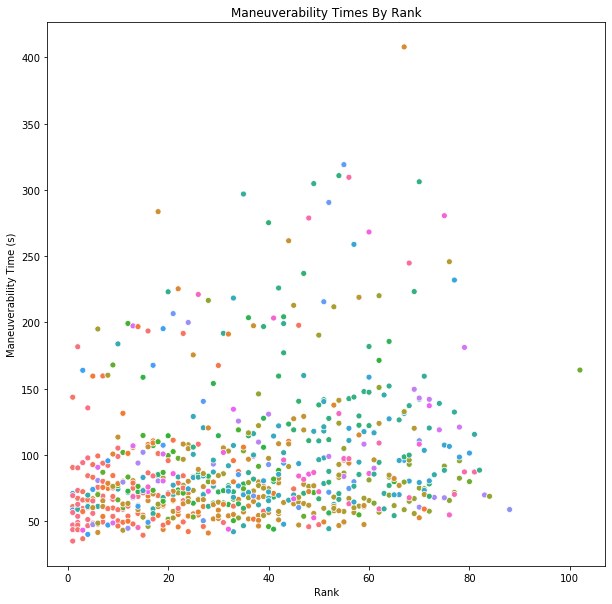

In [15]:
mat.figure(figsize = (10,10))
ax = sb.scatterplot(data = maneuverabilityData, x = "Rank", y = "Maneuverability Time", hue = "School")
mat.xlabel("Rank")
mat.ylabel("Maneuverability Time (s)")
mat.title("Maneuverability Times By Rank")
ax.get_legend().remove()
mat.show()

Unfortunately, as we suspected, shorter Manuverability times don't necessarily equate to higher Rank. It all depends on the length and difficulty of the particular course.

### 3.4 Exploration of Traction Results

For the Traction event, we are somewhat in luck, since distance is part of the scoring criteria, as well as time. This will allow us to calculate an average speed for each vehicle during the traction event. This shoud be somewhat consistent accross different competitions, although we may see some variability between the two different types of traction events. To check this, we'll start with a histogram.

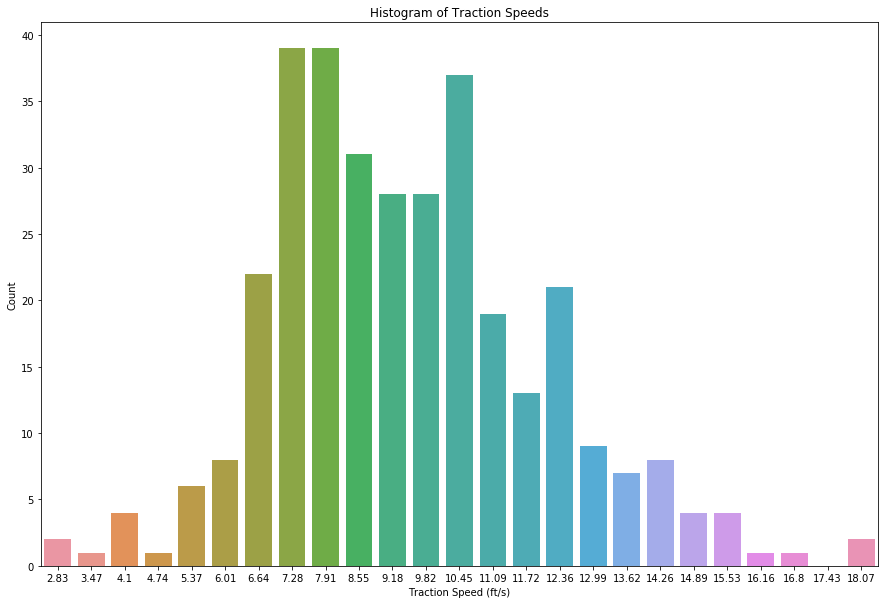

In [16]:
# Calculating speed and distance/time
tractionHist = results.copy()[["Traction Time", "Traction Distance"]]
tractionHist["Traction Speed"] = tractionHist["Traction Distance"] / tractionHist["Traction Time"]
tractionHist = tractionHist[tractionHist["Traction Speed"] != np.inf]

# Splitting the data into bins and counting it
tractionHist["Bins"] = pd.cut(tractionHist["Traction Speed"], bins = 25)
tractionHist = tractionHist.groupby("Bins", as_index = False).count()
tractionHist["Midpoints"] = tractionHist["Bins"].apply(lambda x: x.mid.round(2))

mat.figure(figsize = (15,10))
sb.barplot(data = tractionHist, x = "Midpoints", y = "Traction Speed")
mat.xlabel("Traction Speed (ft/s)")
mat.ylabel("Count")
mat.title("Histogram of Traction Speeds")
mat.show()

As another side note, while we were plotting this data, it became apparent that some teams end up with infinite Traction speeds. Taking a closer look, this seems to be the result of teams being assigned 0.0 s as their best time, often despite having valid times in the individual attept columns from the original data. Fixing this would involve more data wrangling than we'd like to get into at this point, so for now, we'll just drop the infinite values. Like dropping teams that didn't pass their technical inspection, this shouldn't be too problematic, since this doesn't happen for highly-ranked teams anyways.  
Although it may be problematic to treat both types of traction event the same way, and we may want to separate the two in the future, for now, the data looks almost normally distributed. Still, we run into the same issue as we did with the Maneuverability data: easier courses may lead to abnormally high speeds. On top of that, Traction is an event where not every car reaches the end, and getting stuck quickly is as good as useless. We can see this by plotting Traction speed by rank.

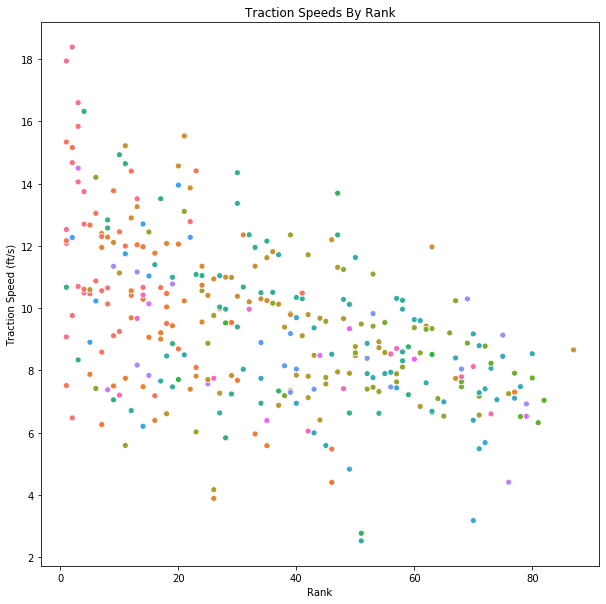

In [17]:
# Calculating speed and distance/time
tractionData = results.copy()[["Rank", "Year", "School", "Location",
                               "Traction Time", "Traction Distance", "Traction (75)"]]
tractionData["Traction Speed"] = tractionData["Traction Distance"] / tractionData["Traction Time"]
tractionData = tractionData[tractionData["Traction Speed"] != np.inf]

mat.figure(figsize = (10,10))
ax = sb.scatterplot(data = tractionData, x = "Rank", y = "Traction Speed", hue = "School")
mat.xlabel("Rank")
mat.ylabel("Traction Speed (ft/s)")
mat.title("Traction Speeds By Rank")
ax.get_legend().remove()
mat.show()

In an attempt to rectify this, we can try to normalize the speeds based on the score earned, which is already intended to rank all the teams, based on the best Distances and Times for that event. Then we'll re-plot with the adjusted times, to see if this helped.

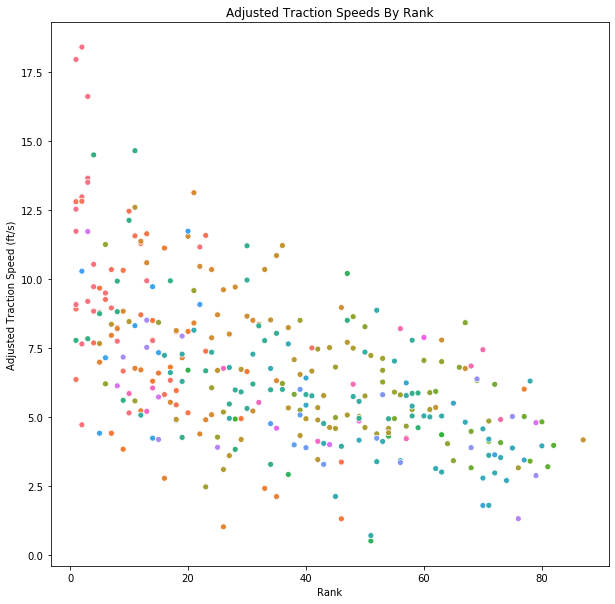

In [18]:
tractionData["Traction Adjusted"] = tractionData["Traction Speed"] * (tractionData["Traction (75)"] / 75)

mat.figure(figsize = (10,10))
ax = sb.scatterplot(data = tractionData, x = "Rank", y = "Traction Adjusted", hue = "School")
mat.xlabel("Rank")
mat.ylabel("Adjusted Traction Speed (ft/s)")
mat.title("Adjusted Traction Speeds By Rank")
ax.get_legend().remove()
mat.show()

Unfortunately, it looks like this didn't help much. This is probably because of the correlation between the speed and score. Still, we can see a rough inverse correlation between Speed and Rank; Overall, better teams tend to be faster, which makes sense.

### 3.5 Exploration of Spectialty Event Results

Despite our limited success looking at the Traction data, which is scored in a very similar way, we'll attempt the same process with the Specialty Event Data. We also note that, there are even more types of Specialty Event (three), so we'll take our findings with a grain of salt.  
Anyways, first we'll plot the histogram.

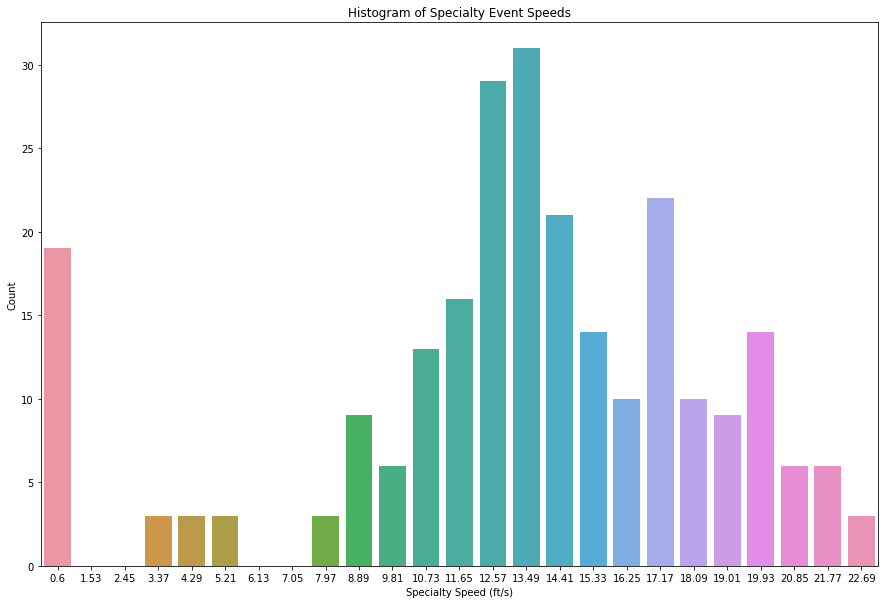

In [19]:
# Calculating speed and distance/time
specialtyHist = results.copy()[["Specialty Time", "Specialty Distance"]]
specialtyHist["Specialty Speed"] = specialtyHist["Specialty Distance"] / specialtyHist["Specialty Time"]
specialtyHist = specialtyHist[specialtyHist["Specialty Speed"] != np.inf]

# Splitting the data into bins and counting it
specialtyHist["Bins"] = pd.cut(specialtyHist["Specialty Speed"], bins = 25)
specialtyHist = specialtyHist.groupby("Bins", as_index = False).count()
specialtyHist["Midpoints"] = specialtyHist["Bins"].apply(lambda x: x.mid.round(2))

mat.figure(figsize = (15,10))
sb.barplot(data = specialtyHist, x = "Midpoints", y = "Specialty Speed")
mat.xlabel("Specialty Speed (ft/s)")
mat.ylabel("Count")
mat.title("Histogram of Specialty Event Speeds")
mat.show()

Even more than before, this is a bit of a mess. We also note that like before, we had to drop some infinite values. This time, we'll skip straight to calculating the adjusted speeds, to see if we can make sense of any of it.

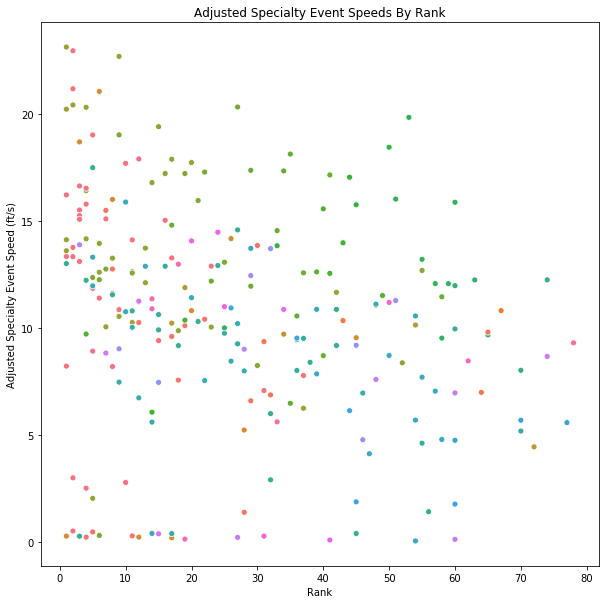

In [20]:
# Calculating speed and distance/time
specialtyData = results.copy()[["Rank", "Year", "School", "Location",
                               "Specialty Time", "Specialty Distance", "Specialty (75)"]]
specialtyData["Specialty Speed"] = specialtyData["Specialty Distance"] / specialtyData["Specialty Time"]
specialtyData = specialtyData[specialtyData["Specialty Speed"] != np.inf]
specialtyData["Specialty Adjusted"] = specialtyData["Specialty Speed"] * (specialtyData["Specialty (75)"] / 75)

mat.figure(figsize = (10,10))
ax = sb.scatterplot(data = specialtyData, x = "Rank", y = "Specialty Adjusted", hue = "School")
mat.xlabel("Rank")
mat.ylabel("Adjusted Specialty Event Speed (ft/s)")
mat.title("Adjusted Specialty Event Speeds By Rank")
ax.get_legend().remove()
mat.show()

Once again, this doesn't look great, although a similar trend appears that better teams are faster.

### 3.6 Exploration of Endurance Results

Similar to manuverability, Endurance results depend heavily on the length of the course. Nevertheless, we'll make a quick boxplot of the numbr of Endurance Laps run by each team over the years, just to seee what happens.

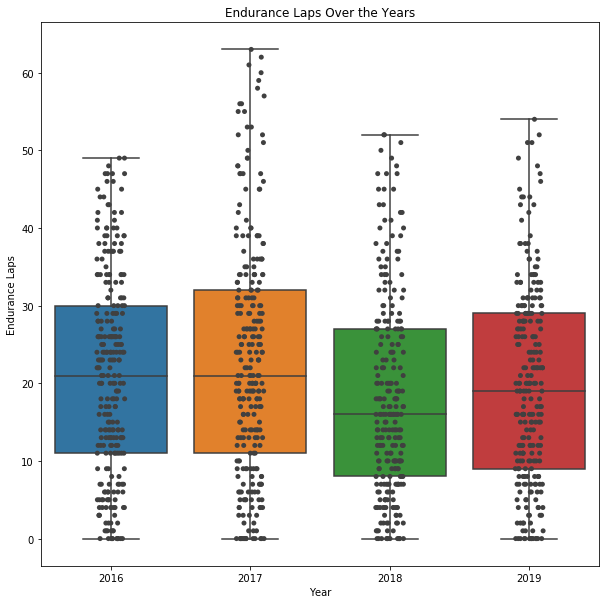

In [21]:
enduranceData = results.copy()[["Year", "Location", "Endurance Laps"]]

mat.figure(figsize = (10,10))
ax = sb.boxplot(data = enduranceData, x = "Year", y = "Endurance Laps", whis=  np.inf)
ax = sb.stripplot(data = enduranceData, x = "Year", y = "Endurance Laps", color = "0.25")
mat.xlabel("Year")
mat.ylabel("Endurance Laps")
mat.title("Endurance Laps Over the Years")
mat.show()

Somewhat surprisingly, we see that the medians tend to float around 20 laps pretty consistently. Still, the upper limits vary quite significantly (by up to 10 laps).

<hr>

## 4. Conclusion

### 4.1 What We Can Say So Far

Overall, we unfortunately have yet to make any groundbreaking conclusions. As it turns out, performance in all the Dynamic events is important to winning. This is especially true, of course, of the Endurance event, which is worth 40% of the total competition points. Beyond that, we disvovered that the next most important thing is the manuverability event. This is interesting since the Manuverability event is one of the most dependant on driver skill, as opposed to Acceleration or Traction which, for the most part, only require the driver to mash the accelerator.  
In terms of gaining any insight from event-specific data, our success was limited. The biggest thing we're missing is a way to compare data accross different competitions, by taking into account course length and difficulty for each. Still, we can say with a fair bit of confidence that a 3.5 s run on a 100 ft Acceleration course is a good target to aim for.  
For the moment, it looks like the closest we could come to our original dream of vehicle optimization wold be to recreate event courses from one of the competitions we attended, to see how we might've faired, had we performed that way at the time. Evidently, this is impractical and not all that useful, so there's a lot of work to be done!

### 4.2 Future Work

Based on the data we already have, there are already a couple things we could do, that we decided not to do for the sake of this project. One, for instance, is to expand our scraper to fix some of the zero values that were giving us trouble when calculating the avergae speeds for the Traction and Specialty events, by grabbing the data from other columns. Another would be to explore the validity of our hypothesis on the importance of driver skill by looking at how close the nearest motocross park is to each school. If we're right, schools closer to places where they can practice might have better drivers, and thus better performance.  
As we touched on above, our analysis made it glaringly obvious that there are some gaps in the available data, if we want to get some more conclusive results. For example, it would've been a good idea to note down the distance used for the Acceleration event while we were there. Betond that, if we could measure the length and "twistiness" of each Manuverability course, that could help us normalize the times and give us a more concrete target to aim for. Although it's unlikely that we'd be able to retroactively dig up this information from past competitions, this is certainly something to take note of for the future. Additionally, certain information might be nice to crowd-source, although it can be difficult to get opponents to collaborate. For instance, it would be incredible if we could eventually predict performance based on tangible vehicle specifications, such as dimensions, weight, and gear ratio range.  
Further to this end, the real dream would be to use machine learning to build a model to help predict performance and thus inform design. As of now, our analysis has yet to reveal any suitable features to use for this. Hopefully, further consideration and data collection will help with this issue.